In [1]:
import pandas as pd
import random
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import math
import os
import matplotlib.transforms as mtransforms
from random import shuffle
from model_parameters import *

# Heaviside function 
def heav(X):
    if X <= 0:
        return 0
    elif X>0:
        return 1
    
# fixed delayed slope
def decimal_range(start, stop, increment):
    while start < stop: # and not math.isclose(start, stop): Py>3.5
        yield start
        start += increment

In [2]:

def run_(simulated_time):
   
    
    """
    Model parameters
    """
    r_glucose =0.0077
    cell_size=0.65
    f_mean_glucose = 0.55
    f_CV_glucose = 0.1
    S0_mean = 0.60
    S0_CV = 0.1    
    SPN_mean = 0.07
    SPN_CV = 0.03
    SPO_mean = 0.07
    SPO_CV = 0.03
    S0_log = np.random.lognormal(np.log(S0_mean),S0_CV,1)[0]

    
    """
    Initial state at G1 phase
    """
    
    cln3=0
    whi5=1
    sbf=0
    cln2=0
    mbf=0
    clb5=0
    ori=0
    mcm1=0
    clb2G=0
    clb2M=0
    cdc20=0
    cdc5=0
    cdc14=0
    swi5=0
    cdh1=1
    sic1=1
    nrm1=0
    sac = 0
    spoc= 0
    spn_progress = 0
    spoc_progress = 0
    time_init = 0
    del_sac=0
    divide_status = ""
    
    init_state = [cln3,whi5,sbf,cln2,mbf,clb5,ori,clb2G,cdc5,mcm1,clb2M,sac,cdc20,spoc,cdc14,swi5,cdh1,sic1,nrm1,
                  time_init,cell_size,S0_log,divide_status,spn_progress,spoc_progress]
    sim_list = [init_state]
    tr_ = simulated_time
    sac_event = [] # to track sac checkpoint event
    
    # when endoreplication start
    clb5_0=0
    k19 = 0.5 #w_Clb2G
    k22 = -0.5 #w_Clb2M
    clb5_div=1
    endo_start = 250
    
    for j in range(tr_):
                   
        cln3_sum = (cell_size >= S0_log)
        whi5_sum = k60 + k61*cdc14 - k62*cln2 - k63*cln3 
        sbf_sum =  k45 + (k47*clb5/clb5_div) + k48*cln2 + k49*cln3 - k46*clb2G - k50*whi5 
        cln2_sum = k30 + k31*mbf + k32*sbf 
        mbf_sum  = k33 + (k35*clb5/clb5_div) + k36*cln2 + k37*cln3 - k34*clb2G - k38*nrm1 
        clb5_sum = k25 + k27*mbf + k28*sbf - k29*sic1 - k26*cdc20 - clb5_0
        clb2G_sum = k19 - k20*cdh1 - k21*sic1
        clb2M_sum =  k22 + k24*mcm1 - k23*cdc20
        mcm1_sum = k39 + k41*clb2M + k40*clb2G
        cdc5_sum = k9 + k11*clb2G + k12*clb2M - k10*cdh1 
        cdc20_sum =  k6 + k7*mcm1 - k8*sac 
        cdc14_sum = k1 + k2*cdc5 - k5*spoc - k4*sac - k3*clb2M
        swi5_sum =  k57 + k58*cdc14 + k59*mcm1 -k64*clb2M - k65*clb2G
        cdh1_sum = k13 + k14*cdc14 - k16*clb2M - (k17*clb5/clb5_div) - k18*cln2 - k15*clb2G
        sic1_sum = k51 + k56*swi5 - k53*clb2M - (k54*clb5/clb5_div) - k55*cln2 - k52*clb2G
        nrm1_sum = k42 - k43*cdh1 + k44*mbf



        """
        Binarizing the sum variables by Heaviside function
        """
        cln3_new = heav(cln3_sum)
        whi5_new = heav(whi5_sum)
        sbf_new = heav(sbf_sum)
        cln2_new = heav(cln2_sum)
        mbf_new = heav(mbf_sum)
        clb5_new = heav(clb5_sum)
        mcm1_new = heav(mcm1_sum)
        clb2M_new = heav(clb2M_sum)
        cdc20_new = heav(cdc20_sum) 
        cdc5_new = heav(cdc5_sum)
        cdc14_new = heav(cdc14_sum) 
        swi5_new = heav(swi5_sum)
        cdh1_new = heav(cdh1_sum)
        sic1_new = heav(sic1_sum)
        clb2G_new = heav(clb2G_sum)
        nrm1_new = heav(nrm1_sum)


        """
        Which variables change?
        """

        cln3_update = cln3_new - cln3
        whi5_update = whi5_new - whi5
        sbf_update =  sbf_new - sbf
        cln2_update = cln2_new - cln2
        mbf_update  = mbf_new - mbf
        clb5_update = clb5_new - clb5
        mcm1_update = mcm1_new - mcm1
        clb2M_update = clb2M_new - clb2M
        cdc20_update = cdc20_new - cdc20
        cdc5_update = cdc5_new - cdc5
        cdc14_update = cdc14_new - cdc14
        swi5_update = swi5_new - swi5
        cdh1_update = cdh1_new - cdh1
        sic1_update = sic1_new - sic1
        clb2G_update = clb2G_new - clb2G
        nrm1_update = nrm1_new - nrm1


        """
        Selecting a single variable to change with a uniform asynchronous update
        """

        x1 = abs(cln3_update)
        x2 = x1 + abs(whi5_update)
        x3 = x2 + abs(sbf_update)
        x4 = x3 + abs(cln2_update)
        x5 = x4 + abs(mbf_update)
        x6 = x5 + abs(clb5_update)
        x7 = x6 + abs(mcm1_update)
        x8 = x7 + abs(clb2M_update)
        x9 = x8 + abs(cdc20_update)
        x10 = x9 + abs(cdc5_update)
        x11 = x10 + abs(cdc14_update)
        x12 = x11 + abs(swi5_update)
        x13 = x12 + abs(cdh1_update)
        x14 = x13 + abs(sic1_update)
        x15 = x14 + abs(clb2G_update)
        x16 = x15 + abs(nrm1_update)

        if x16 == 0:
            x17 = 1
        else:
            x17 = x16


        sel = random.uniform(0,1)*x17

        y1 = (sel<=x1)
        y2 = (sel>x1)&(sel<=x2)
        y3 = (sel>x2)&(sel<=x3)
        y4 = (sel>x3)&(sel<=x4)
        y5 = (sel>x4)&(sel<=x5)
        y6 = (sel>x5)&(sel<=x6)
        y7 = (sel>x6)&(sel<=x7)
        y8 = (sel>x7)&(sel<=x8)
        y9 = (sel>x8)&(sel<=x9)
        y10 = (sel>x9)&(sel<=x10)
        y11 = (sel>x10)&(sel<=x11)
        y12 = (sel>x11)&(sel<=x12)
        y13 = (sel>x12)&(sel<=x13)
        y14 = (sel>x13)&(sel<=x14)
        y15 = (sel>x14)&(sel<=x15)
        y16 = (sel>x15)&(sel<=x16)
        y17 = (sel>x16)

            
        """
        Updating time
        """
        
        delt = np.random.gamma(3,0.3)
        
        # Adding delay to strain with endoreplication event
        if time_init >= endo_start:
            
            if (clb5 == 0 and clb5_new == 1 and y6 == 1):
                delt = delt = np.random.gamma(clb5_delay,clb5_cv_delay)

            if (cdh1 == 1 and cdh1_new == 0 and y13 == 1):
                delt = np.random.gamma(cdh1_delay_OFF,cdh1_delay_cv_OFF)
      
    
               
        time_init = time_init + delt


        """
        Updating size
        """ 
        if(clb2G == 1 and clb2G_new == 0 and y15 == 1):
            
            f = np.random.lognormal(np.log(f_mean_glucose),f_CV_glucose, 1)[0]
            S0_log  = np.random.lognormal(np.log(S0_mean),S0_CV,1)[0]
            cell_size = cell_size*math.exp(r_glucose*delt) * f
            divide_status = "divided !!!"

        else:
            
            cell_size = cell_size*math.exp(r_glucose*delt)
            divide_status = ""



        """
        Updating protein activity
        """

        cln3 = cln3 + cln3_update*y1
        whi5 = whi5 + whi5_update*y2
        sbf =  sbf + sbf_update*y3
        cln2 = cln2 + cln2_update*y4
        mbf =  mbf + mbf_update*y5
        clb5 = clb5 + clb5_update*y6
        mcm1 = mcm1 + mcm1_update*y7
        clb2M = clb2M + clb2M_update *y8
        cdc20 = cdc20 + cdc20_update*y9
        cdc5 = cdc5 + cdc5_update*y10
        cdc14 = cdc14 + cdc14_update*y11
        swi5 = swi5 + swi5_update*y12
        cdh1 = cdh1 + cdh1_update*y13
        sic1 = sic1 + sic1_update*y14
        clb2G = clb2G + clb2G_update*y15
        nrm1 = nrm1 + nrm1_update*y16
        
        
        """
        Switch cln3/whi5 based on cell size
        """
        if cell_size < S0_log:
            cln3,whi5 = 0,1
        else:
            cln3,whi5 = 1,0

        if time_init >= endo_start:
            clb2G=0
            clb2M=0
            k19=0
            k22=0
            clb5_0=0.6
            cdh1_delay_OFF = 15
            cdh1_delay_cv_OFF = 1.5
            clb5_delay = 15
            clb5_cv_delay = 1.5
            clb5_div=8

         

        """
        ORI begin
        """
    
        if (clb5 == 1 or clb2M == 1 or clb2G == 1):
            ori = 1
        else:
            ori = 0

        """
        SAC Checkpoint
        """
        
        if (ori == 1 and spn_progress < 1):
            sac=1
        else:
            sac=0

            
        if(clb2M == 1 and sac == 1):
            
            num =  np.random.lognormal(np.log(SPN_mean),SPN_CV,1)[0]
            spn_progress += num
            
            if spn_progress >= 1:
                spn_progress = 1
         
        
        """
        SPoC Checkpoint
        """
        # 10 = the starting time step for monitoring SAC checkpoint
        if j >= 10:
            t_previous = sac_event[j-2]
            t_current = sac_event[j-1]

            del_sac = t_current-t_previous
        
        if (cdc20 == 1 and del_sac == -1 and spoc_progress < 1):
            spoc = 1
            
        elif spoc_progress >= 1:
            spoc = 0
        
                
        ## SPoC progress
        if(cdc20 == 1 and spoc == 1):
            num = np.random.lognormal(np.log(SPO_mean),SPO_CV,1)[0]
            spoc_progress += num
            if spoc_progress >= 1:
                spoc_progress = 1
                
                
        """
        Resetting progress variables when the progress is done, e.g., spindle progress reset back to zero when anaphase start (cdc20 = 1) 
        """
    
    
        if cdc20 == 1:
            spn_progress = 0
            sac = 0 
        
        if cdc14 == 1:
            spoc_progress = 0
            spoc = 0

            
        res_ = [cln3,whi5,sbf,cln2,mbf,clb5,ori,clb2G,cdc5,mcm1,clb2M,sac,cdc20,spoc,cdc14,swi5,cdh1,sic1,nrm1,
                time_init,cell_size,S0_log,divide_status,spn_progress,spoc_progress]   
            
        sim_list.append(res_)
        sac_event.append(sac)
        
    return sim_list

In [518]:
dff = run_(350)
node_name = ["cln3","whi5","sbf","cln2", "mbf","clb5","ori", "clb2G", "cdc5","mcm1","clb2","sac", "cdc20","spoc","cdc14","swi5","cdh1","sic1","nrm1"]
df_sim = pd.DataFrame(dff,columns=node_name+["time","cell_size","critical_size","divide","SPN","SPOC"])
cdh1_p = np.array(df_sim["cdh1"])
mbf_p = np.array(df_sim["mbf"])
clb5_p = np.array(df_sim["clb5"])
nrm1_p = np.array(df_sim["nrm1"])
ts = np.array(df_sim["time"])
cs = np.array(df_sim["cell_size"])

In [519]:
dict_ = {"Cdh1":cdh1_p,"Nrm1":nrm1_p,"Clb6":clb5_p,"MBF":mbf_p}
activities_list = []
for i in dict_.keys():
    dat = pd.DataFrame(dict_[i],columns=["value"])
    dat["index"] = i
    dat["ts"] = ts
    activities_list.append(dat)
    
dat_cat = pd.concat(activities_list)
table = pd.pivot_table(dat_cat, values='value', index="index",columns="ts")


time_list = []
ts_col = table.columns.tolist()
for ts_df in range(len(ts_col)-1):
    
    old_index = ts_df
    new_index = ts_df+1
    
    old_c = ts_col[old_index]
    new_c = ts_col[new_index]
  
    int_  = new_c - old_c
    if int_ >= 3:
        time_list.append(ts_df)
        
df_list = []
for _ in time_list:
    
    start_time = _
    end_time = _ + 1
    
    st_real = ts_col[start_time]
    end_real = ts_col[end_time]
    
    #add time
    add_time = [in_time for in_time in decimal_range(st_real,end_real,1e-2)]
    df_p = pd.concat([table.iloc[:,_]]*len(add_time),axis=1)
    df_p.columns = add_time
    df_list.append(df_p)

    df_add = pd.concat(df_list,axis=1)
    
df_add_1 = pd.concat([table,df_add],axis=1)
df_plot = df_add_1.reset_index().melt(id_vars="index")
cs_df=pd.DataFrame(cs,columns=["value"])
cs_df["variable"] = ts
cs_df["index"] = "cell_size"
all_df = pd.concat([df_plot,cs_df]).reset_index().iloc[:,1:]
#all_df.to_csv("../data/Fig5A.csv")


/var/folders/m_/w2wt9y5n2bg0k03_n88pwc9r0000gn/T/ipykernel_1166/3890468956.py:33: DtypeWarning: Columns (23) have mixed types. Specify dtype option on import or set low_memory=False.
  df_time = pd.read_csv("../data/Fig5B.csv")


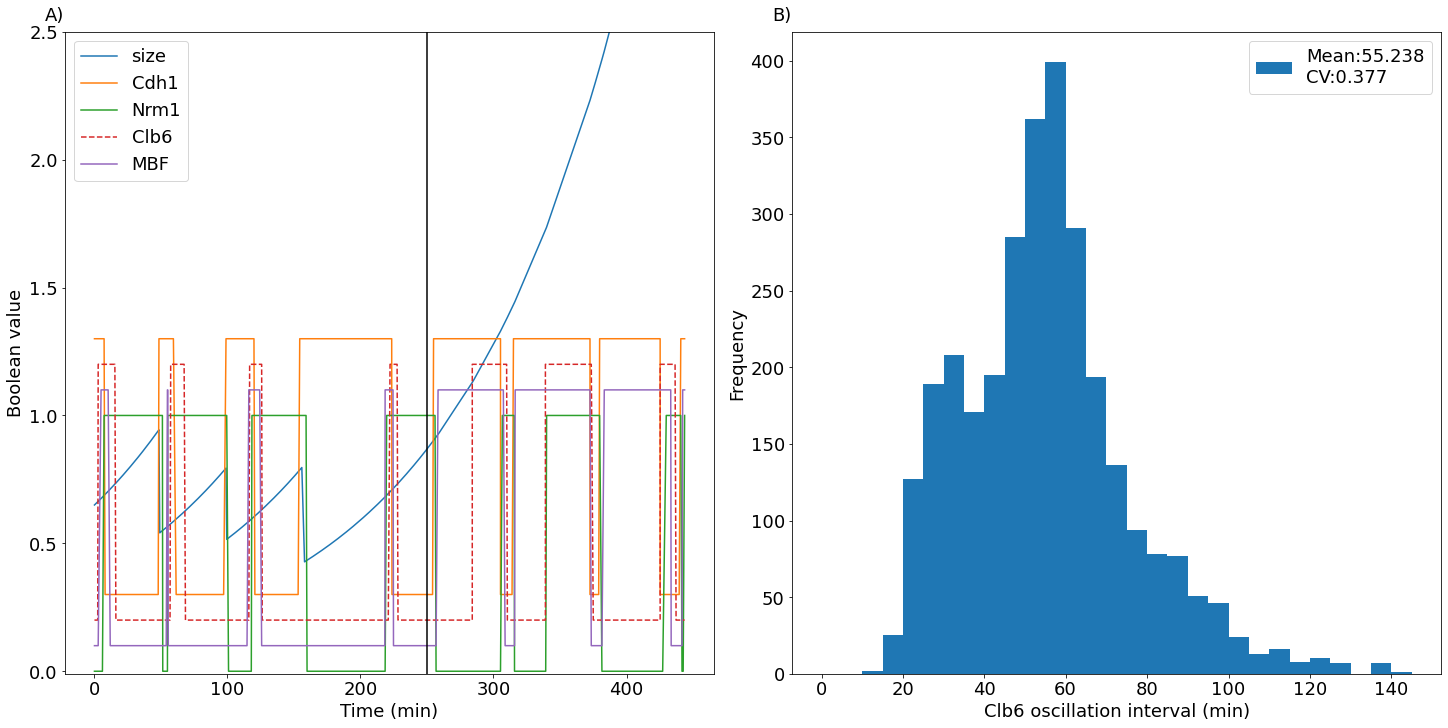

In [521]:
fig = plt.figure(layout= 'constrained', figsize=(20,10))
axs = fig.subplot_mosaic([['A)', 'B)']])
XX=18
"""
A
"""
df_size = pd.read_csv("../data/Fig5A.csv").query("variable <= 2000")
def line_(X):
    FD = df_size.query("index == @X").sort_values(by="variable")
    FD2 = FD.variable
    FD3 = FD.value
    return [FD2,FD3]

axs["A)"].plot(line_("cell_size")[0],line_("cell_size")[1], label ='size')
axs["A)"].plot(line_("Cdh1")[0],line_("Cdh1")[1]+0.3, label ='Cdh1')
axs["A)"].plot(line_("Nrm1")[0],line_("Nrm1")[1], label ='Nrm1')
axs["A)"].plot(line_("Clb6")[0],line_("Clb6")[1]+0.2, label ='Clb6',linestyle='--')
axs["A)"].plot(line_("MBF")[0],line_("MBF")[1]+0.1, label ='MBF')
axs["A)"].set_ylim(-0.01,2.5)
axs["A)"].axvline(x=250,color='black')
axs["A)"].legend(loc="upper left",fontsize=XX)
axs["A)"].set_xlabel("Time (min)",fontsize=XX)
axs["A)"].set_ylabel("Boolean value",fontsize=XX)
axs['A)'].tick_params(labelsize=XX)

"""
B
"""
#dff_time = run_(100000)
#node_name = ["cln3","whi5","sbf","cln2", "mbf","clb5","ori", "clb2G", "cdc5","mcm1","clb2","sac", "cdc20","spoc","cdc14","swi5","cdh1","sic1","nrm1"]
#df_time = pd.DataFrame(dff_time,columns=node_name+["time","cell_size","critical_size","divide","SPN","SPOC"])
#df_time.to_csv("../data/Fig5B.csv")
df_time = pd.read_csv("../data/Fig5B.csv")
df5 = df_time.iloc[5000:,:][["time","clb5"]]
X = df5.clb5.to_numpy()

peak_list = []
for cc in range(len(X)-1):
    old_index = cc
    new_index = cc+1
    
    old_c = X[old_index]
    new_c = X[new_index]
    
    sub_ = new_c-old_c
    
    if sub_ == -1:
        peak_list.append(cc)
        
df6 = df5.iloc[peak_list[1:],:]
diff_peak = list(df6['time'] - df6['time'].shift())[1:][::2]

axs["B)"].hist(diff_peak,bins=[_ for _ in range(0,150,5)],label="Mean:"+str(round(np.mean(diff_peak),3))+"\nCV:"+str(round(np.std(diff_peak)/np.mean(diff_peak),3)))
axs["B)"].set_xlabel("Clb6 oscillation interval (min)",fontsize=XX)
axs["B)"].set_ylabel("Frequency",fontsize=XX)
axs["B)"].legend(fontsize=XX)
axs['B)'].tick_params(labelsize=XX)

for label, ax in axs.items():
    # label physical distance to the left and up:
    trans = mtransforms.ScaledTranslation(-20/72, 7/72, fig.dpi_scale_trans)
    ax.text(0.0, 1.0, label, transform=ax.transAxes + trans,
            fontsize=XX, va='bottom')

plt.savefig('../figures/fig5.pdf',format="pdf", bbox_inches="tight")
plt.show()
